# 1. What Is Feature Engineering

## Welcome to Feature Engineering!
In this course you'll learn about one of the most important steps on the way to building a great machine learning model: *feature engineering*. You'll learn how to:
- determine which features are the most important with *mutual information*
- invent new features in several real-world problem domains
- encode high-cardinality categoricals with a *target encoding*
- create segmentation features with *k-means clustering*
- decompose a dataset's variation into features with *principal componenet analysis*

the hands-on exercises build up to a complete **notbook** that applies all of these techniques to make a submission to the **House Prices Getting Started** competition. After completing this course, you'll have several ideas that you can use to further improve your performance.

Are you ready? Let's go!

## The Goal of  Feature Engineering
The goal of feature engineering is simply to make your data better suited to the problem at hand.

Consider "apparent temperature" measures like the heat index and the wind chill. These quantities attempt to measure the *perceived* temperature to humans based on air temperature, humidity, and wind speed, things which we can measure directly. You could think of an apparent temperature as the result of a kind of feature engineering, an attempt to make the observed data more relevant to what we actually care about: how it actually feels outside!

You might perform feature engineering to:

- improve a model's predictive performance
- reduce computational or data needs
- improve interpretability of the results

## A Guiding Principle of Feature Engineering
For a feature to be useful, it must have a relationship to the target that your model is able to learn. Linear models, for instance, are only able to learn linear relationships. So, when using a linear model, your goal is to transform the features to make their relationship to the target linear.

The Key idea here is that a transformation you apply to a feature becomes in essence a part of the model itself. Say you were trying to predict the `Price` of square plots of land from the `Length` of one side. Fitting a linear model directly to `Length` gives poor results: the relationship is not linear.

<!-- <center> 
![image]
(https://storage.googleapis.com/kaggle-media/learn/images/5D1z24N.png)
</center> -->
<p align="center">
<img src="https://storage.googleapis.com/kaggle-media/learn/images/5D1z24N.png">
</p>
<center> *A linear model fits poorly with only Length as feature.* </center>

If we square the `Length` feature to get `'Area'`, however, we create a linear relationship. Adding `Area` to the feature set means this linear model can now fit a parabola. Squaring a feature, in other words, gave the linear model the ability to fit squared features.
<p align="center">
<img src="https://storage.googleapis.com/kaggle-media/learn/images/BLRsYOK.png">
</p>
<center> *Left: The fit to Area is much better. Right: Which makes the fit to Length better as well.* </center>
This should show you why there can be such a high return on time invested in feature engineering. Whatever relationships your model can't learn, you can provide yourself through transformations. As you develop your feature set, think about what information your model could use to achieve its best performance.

<!-- 
```mermaid
graph LR
A(입력)->
B->C(출력)
```
```sequence
Alice->Bob: Hello Bob, how are you?
Note right of Bob: Bob thinks
Bob->Alice: I am good thanks!
``` 
-->

## Example - Concrete Formulations
To illustrate these ideas we'll see how adding a few synthetic features to a dataset can improve the predictive performance of a random forest model.

The *Concrete* dataset contains a variety of concrete formulations and the resulting product's *compressive strength*, which is a measure of how much load that kind of concrete can bear. The task for this dataset is to predict a concrete's compressive strength given its formulation.

In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

df = pd.read_csv("../input/fe-course-data/concrete.csv")
df.head()

,Cement,BlastFurnaceSlag,FlyAsh,Water,Superplasticizer,CoarseAggregate,FineAggregate,Age,CompressiveStrength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


You can see here the various ingredients going into each variety of concrete. We'll see in a moment how adding some additional synthetic features derived from these can help a model to learn important relationships among them.

We'll first establish a baseline by training the model on the un-augmented dataset. This will help us determine whether our new features are actually useful.

Establishing baselines like this is good practice at the start of the feature engineering process. A baseline score can help you decide whether your new features are worth keeping, or whether you should discard them and possibly try something else.

In [2]:
X = df.copy()
y = X.pop("CompressiveStrength")

# Train and score baseline model
baseline = RandomForestRegressor(criterion="absolute_error", random_state=0)
baseline_score = cross_val_score(
    baseline, X, y, cv=5, scoring="neg_mean_absolute_error"
)
baseline_score = -1 * baseline_score.mean()

print(f"MAE Baseline Score: {baseline_score:.4}")

MAE Baseline Score: 8.232


If you ever cook at home, you might know that the *ratio* of ingredients in a recipe is usually a better predictor of how the recipe turns out than their absolute amounts. We might reason then that ratios of the features above would be a good predictor of `CompressiveStrength`.

The cell below adds three new ratio features to the dataset.

In [3]:
X = df.copy()
y = X.pop("CompressiveStrength")

# Create synthetic features
X["FCRatio"] = X["FineAggregate"] / X["CoarseAggregate"]
X["AggCmtRatio"] = (X["CoarseAggregate"] + X["FineAggregate"]) / X["Cement"]
X["WtrCmtRatio"] = X["Water"] / X["Cement"]

# Train and score model on dataset with additional ratio features
model = RandomForestRegressor(criterion="absolute_error", random_state=0)
score = cross_val_score(
    model, X, y, cv=5, scoring="neg_mean_absolute_error"
)
score = -1 * score.mean()

print(f"MAE Score with Ratio Features: {score:.4}")

MAE Score with Ratio Features: 7.948


And sure enough, performance improved! This is evidence that these new ratio features exposed important information to the model that it wasn't detecting before.

## Continue
We've seen that engineering new features can improve model performance. But how do you identify features in the dataset that might be useful to combine? Discover useful features with mutual information.

# 2. Mutual Information

## Tutorial



### **Introduction**
First encountering a new dataset can sometimes feel overwhelming. You might be presented with hundreds or thousands of features without even a description to go by. Where do you even begin?

A great first step is to construct a ranking with a **feature utility metric**, a function measuring associations between a feature and the target. Then you can choose a smaller set of the most useful features to develop initially and have more confidence that your time will be well spent.

The metric we'll use is called "mutual information". Mutual information is a lot like correlation in that it measures a relationship between two quantities. The advantage of mutual information is that it can detect *any* kind of relationship, while correlation only detects *linear* relationships.

Mutual information is a great general-purpose metric and especially useful at the start of feature development when you might not know what model you'd like to use yet. It is:
- easy to use and interpret,
- computationally efficient,
- theoretically well-founded,
- resistant to overfitting, and,
- able to detect any kind of relationship

### **Mutual Information and What it Measures**
Mutual information describes relationships in terms of *uncertainty*. The **mutual information** (MI) between two quantities is a measure of the extent to which knowledge of one quantity reduces uncertainty about the other. If you knew the value of a feature, how much more confident would you be about the target?

Here's an example from the *Ames Housing* data. The figure shows the relationship between the exterior quality of a house and the price it sold for. Each point represents a house.

<p align="center">
<img src="https://storage.googleapis.com/kaggle-media/learn/images/X12ARUK.png">
</p>
<center>Knowing the exterior quality of a house reduces uncertainty about its sale price.</center>

From the figure, we can see that knowing the value of `ExterQual` should make you more certain about the corresponding `SalePrice` -- each category of `ExterQual` tends to concentrate `SalePrice` to within a certain range. The mutual information that `ExterQual` has with `SalePrice` is the average reduction of uncertainty in `SalePrice` taken over the four values of `ExterQual`. Since `Fair` occurs less often than `Typical`, for instance, `Fair` gets less weight in the MI score.

(Technical note: What we're calling uncertainty is measured using a quantity from information theory known as "entropy". The entropy of a variable means roughly: "how many yes-or-no questions you would need to describe an occurance of that variable, on average." The more questions you have to ask, the more uncertain you must be about the variable. Mutual information is how many questions you expect the feature to answer about the target.)

### **Interpreting Mutual Information Scores**
The least possible mutual information between quantities is 0.0. When MI is zero, the quantities are independent: neither can tell you anything about the other. Conversely, in theory there's no upper bound to what MI can be. In practice though values above 2.0 or so are uncommon. (Mutual information is a logarithmic quantity, so it increases very slowly.)

The next figure will give you an idea of how MI values correspond to the kind and degree of association a feature has with the target.

<p align="center">
<img src="https://storage.googleapis.com/kaggle-media/learn/images/Dt75E1f.png">
</p>
<center>Left: Mutual information increases as the dependence between feature and target becomes tighter. Right: Mutual information can capture any kind of association (not just linear, like correlation.)</center>

Here are some things to remember when applying mutual information:

- MI can help you to understand the *relative potential* of a feature as a predictor of the target, considered by itself.
- It's possible for a feature to be very informative when interacting with other features, but not so informative all alone. MI can't detect interactions between features. It is a **univariate** metric.
- The *actual* usefulness of a feature *depends on the model you use it with*. A feature is only useful to the extent that its relationship with the target is one your model can learn. Just because a feature has a high MI score doesn't mean your model will be able to do anything with that information. You may need to transform the feature first to expose the association.

### **Example - 1985 Automobiles**
The *Automobile* dataset consists of 193 cars from the 1985 model year. The goal for this dataset is to predict a car's `price` (the target) from 23 of the car's features, such as `make`, `body_style`, and `horsepower`. In this example, we'll rank the features with mutual information and investigate the results by data visualization.

This hidden cell imports some libraries and loads the dataset.

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

plt.style.use("seaborn-v0_8-whitegrid")

df = pd.read_csv("../input/fe-course-data/autos.csv")
df.head()

,symboling,make,fuel_type,aspiration,num_of_doors,body_style,drive_wheels,engine_location,wheel_base,length,...,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,3,alfa-romero,gas,std,2,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9,111,5000,21,27,13495
1,3,alfa-romero,gas,std,2,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9,111,5000,21,27,16500
2,1,alfa-romero,gas,std,2,hatchback,rwd,front,94.5,171.2,...,152,mpfi,2.68,3.47,9,154,5000,19,26,16500
3,2,audi,gas,std,4,sedan,fwd,front,99.8,176.6,...,109,mpfi,3.19,3.40,10,102,5500,24,30,13950
4,2,audi,gas,std,4,sedan,4wd,front,99.4,176.6,...,136,mpfi,3.19,3.40,8,115,5500,18,22,17450


The scikit-learn algorithm for MI treats discrete features differently from continuous features. Consequently, you need to tell it which are which. As a rule of thumb, anything that *must* have a `float` dtype is *not* discrete. Categoricals (`object` or `categorial` dtype) can be treated as discrete by giving them a label encoding. (You can review label encodings in our Categorical Variables lesson.)

In [4]:
import pandas as pd
import numpy as np
from sklearn.metrics import mutual_info_score

# 예시 데이터 프레임 생성
data = {
    'Feature1': [1, 2, 3, 4, 5],
    'Feature2': ['A', 'B', 'A', 'B', 'A'],
    'Target': [0, 1, 0, 1, 0]
}

df = pd.DataFrame(data)

# Mutual Information을 계산할 두 변수 선택
feature1 = df['Feature1']
feature2 = df['Feature2']
target = df['Target']

# Mutual Information 계산
mi_score_feature1_target = mutual_info_score(feature1, target)
mi_score_feature2_target = mutual_info_score(feature2, target)

# 결과 출력
print(f'Mutual Information between Feature1 and Target: {mi_score_feature1_target}')
print(f'Mutual Information between Feature2 and Target: {mi_score_feature2_target}')


Mutual Information between Feature1 and Target: 0.6730116670092563
Mutual Information between Feature2 and Target: 0.6730116670092563


## Introduction

In this exercise you'll identify an initial set of features in the [*Ames*](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data) dataset to develop using mutual information scores and interaction plots.

Run this cell to set everything up!

In [5]:
# Setup feedback system
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression
#print(plt.style.available)
# Set Matplotlib defaults
plt.style.use("seaborn-v0_8-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

# Load data
df = pd.read_csv("../input/fe-course-data/ames.csv")

# Utility functions from Tutorial
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

-------------------------------------------------------------------------------

To start, let's review the meaning of mutual information by looking at a few features from the *Ames* dataset.

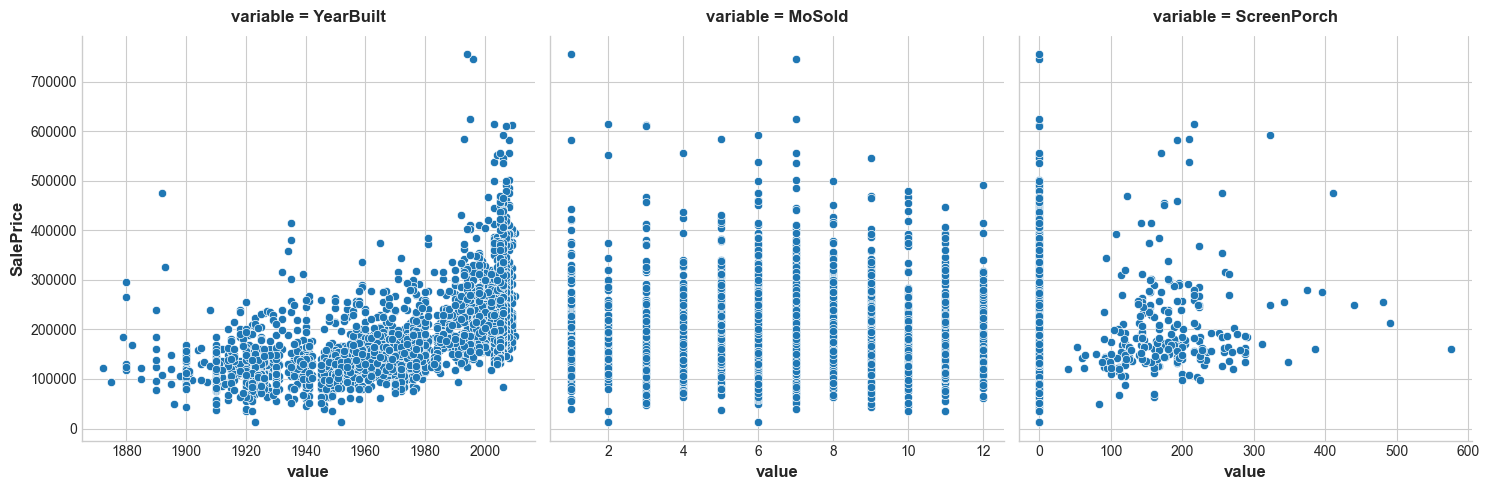

In [6]:
features = ["YearBuilt", "MoSold", "ScreenPorch"]
sns.relplot(
    x="value", y="SalePrice", col="variable", data=df.melt(id_vars="SalePrice", value_vars=features), facet_kws=dict(sharex=False),
);

## 1) Understand Mutual Information

Based on the plots, which feature do you think would have the highest mutual information with `SalePrice`?

In [7]:
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YearSold,SaleType,SaleCondition,SalePrice
0,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,141.0,31770.0,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,...,0.0,No_Pool,No_Fence,NaN,0.0,5,2010,WD,Normal,215000
1,One_Story_1946_and_Newer_All_Styles,Residential_High_Density,80.0,11622.0,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,...,0.0,No_Pool,Minimum_Privacy,NaN,0.0,6,2010,WD,Normal,105000
2,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,81.0,14267.0,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,...,0.0,No_Pool,No_Fence,Gar2,12500.0,6,2010,WD,Normal,172000
3,One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,93.0,11160.0,Pave,No_Alley_Access,Regular,Lvl,AllPub,Corner,...,0.0,No_Pool,No_Fence,NaN,0.0,4,2010,WD,Normal,244000
4,Two_Story_1946_and_Newer,Residential_Low_Density,74.0,13830.0,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Inside,...,0.0,No_Pool,Minimum_Privacy,NaN,0.0,3,2010,WD,Normal,189900


-------------------------------------------------------------------------------

The *Ames* dataset has seventy-eight features -- a lot to work with all at once! Fortunately, you can identify the features with the most potential.

Use the `make_mi_scores` function (introduced in the tutorial) to compute mutual information scores for the *Ames* features:


In [13]:
X = df.copy()
y = X.pop('SalePrice')

mi_scores = make_mi_scores(X, y)

Now examine the scores using the functions in this cell. Look especially at top and bottom ranks.

OverallQual     0.581262
Neighborhood    0.569813
GrLivArea       0.496909
YearBuilt       0.437939
GarageArea      0.415014
TotalBsmtSF     0.390280
GarageCars      0.381467
FirstFlrSF      0.368825
BsmtQual        0.364779
KitchenQual     0.326194
ExterQual       0.322390
YearRemodAdd    0.315402
MSSubClass      0.287131
GarageFinish    0.265440
FullBath        0.251693
Foundation      0.236115
LotFrontage     0.233334
GarageType      0.226117
FireplaceQu     0.221955
SecondFlrSF     0.200658
Name: MI Scores, dtype: float64


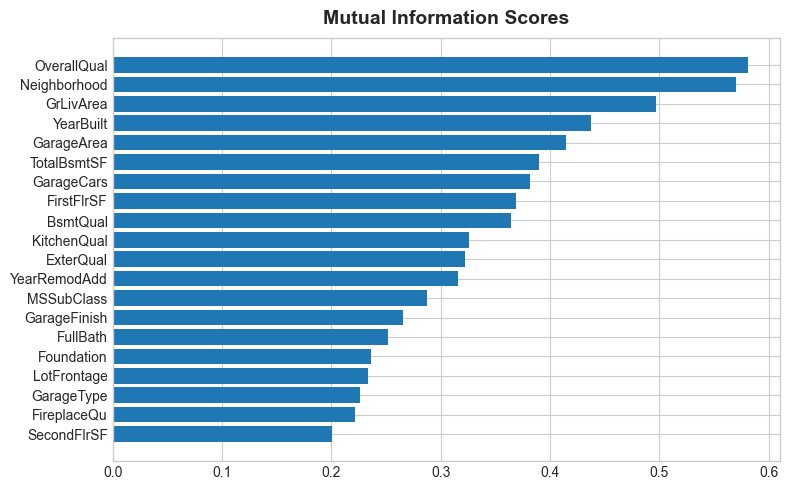

In [9]:
print(mi_scores.head(20))
# print(mi_scores.tail(20))  # uncomment to see bottom 20

plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores.head(20))
# plot_mi_scores(mi_scores.tail(20))  # uncomment to see bottom 20

## 2) Examine MI Scores

Do the scores seem reasonable? Do the high scoring features represent things you'd think most people would value in a home? Do you notice any themes in what they describe? 

-------------------------------------------------------------------------------

In this step you'll investigate possible interaction effects for the `BldgType` feature. This feature describes the broad structure of the dwelling in five categories:

> Bldg Type (Nominal): Type of dwelling
>		
>       1Fam	Single-family Detached	
>       2FmCon	Two-family Conversion; originally built as one-family dwelling
>       Duplx	Duplex
>       TwnhsE	Townhouse End Unit
>       TwnhsI	Townhouse Inside Unit

The `BldgType` feature didn't get a very high MI score. A plot confirms that the categories in `BldgType` don't do a good job of distinguishing values in `SalePrice` (the distributions look fairly similar, in other words):

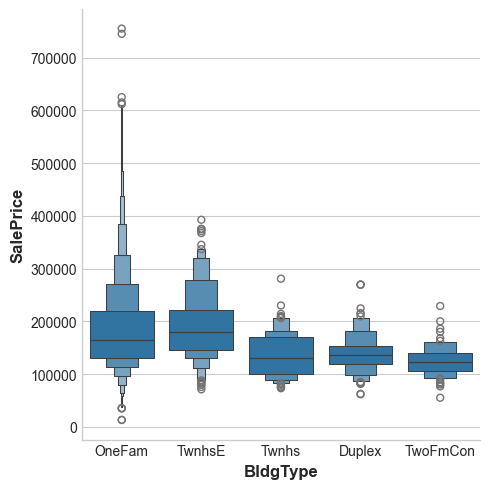

In [10]:
sns.catplot(x="BldgType", y="SalePrice", data=df, kind="boxen");

Still, the type of a dwelling seems like it should be important information. Investigate whether `BldgType` produces a significant interaction with either of the following:

```
GrLivArea  # Above ground living area
MoSold     # Month sold
```

Run the following cell twice, the first time with `feature = "GrLivArea"` and the next time with `feature="MoSold"`:

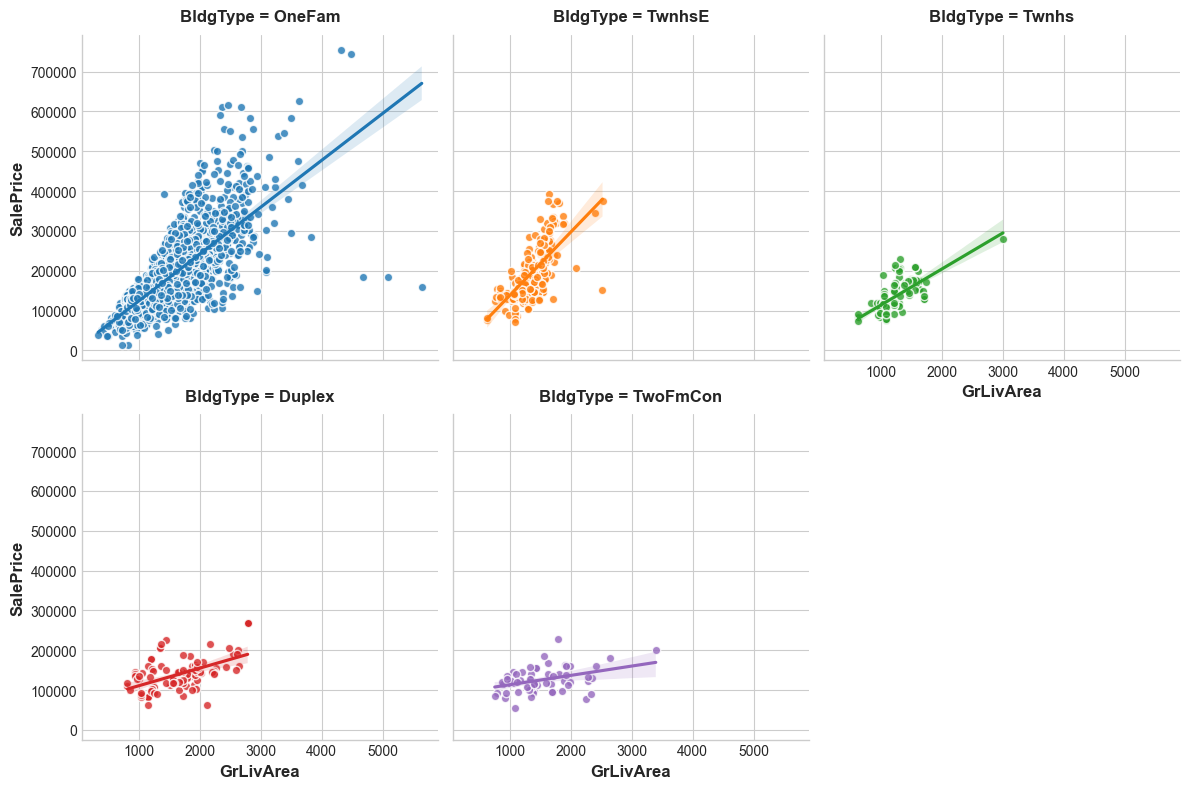

In [11]:
# YOUR CODE HERE: 
feature = "GrLivArea"

sns.lmplot(
    x=feature, y="SalePrice", hue="BldgType", col="BldgType",
    data=df, scatter_kws={"edgecolor": 'w'}, col_wrap=3, height=4,
);

The trend lines being significantly different from one category to the next indicates an interaction effect.

## 3) Discover Interactions

From the plots, does `BldgType` seem to exhibit an interaction effect with either `GrLivArea` or `MoSold`?

## A First Set of Development Features #

Let's take a moment to make a list of features we might focus on. In the exercise in Lesson 3, you'll start to build up a more informative feature set through combinations of the original features you identified as having high potential.

You found that the ten features with the highest MI scores were:

In [12]:
mi_scores.head(10)

OverallQual     0.581262
Neighborhood    0.569813
GrLivArea       0.496909
YearBuilt       0.437939
GarageArea      0.415014
TotalBsmtSF     0.390280
GarageCars      0.381467
FirstFlrSF      0.368825
BsmtQual        0.364779
KitchenQual     0.326194
Name: MI Scores, dtype: float64

Do you recognize the themes here? Location, size, and quality. You needn't restrict development to only these top features, but you do now have a good place to start. Combining these top features with other related features, especially those you've identified as creating interactions, is a good strategy for coming up with a highly informative set of features to train your model on.

## Keep Going #

[**Start creating features**](https://www.kaggle.com/ryanholbrook/creating-features) and learn what kinds of transformations different models are most likely to benefit from.